In [1]:
import sys,os
sys.path.append(os.path.abspath(".."))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
from QuantumWalkModule.TwoDimensionQW import *

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"currently used device : {device}")

currently used device : cpu


In [5]:
plt.rc('font', family='serif')

<h1>2 Dimensional QW</h1>

In [9]:
dimx, dimy = 81,81

x_coin_dict = {
    "th" : np.pi/2
}
y_coin_dict = {
    "th" : np.pi/2
}
init_state_dict = {
    "a" : 1,
    "b" : 1j
}

model = SimpleWalk2D(dimx,dimy,x_coin_dict,y_coin_dict,init_state_dict,device = device)

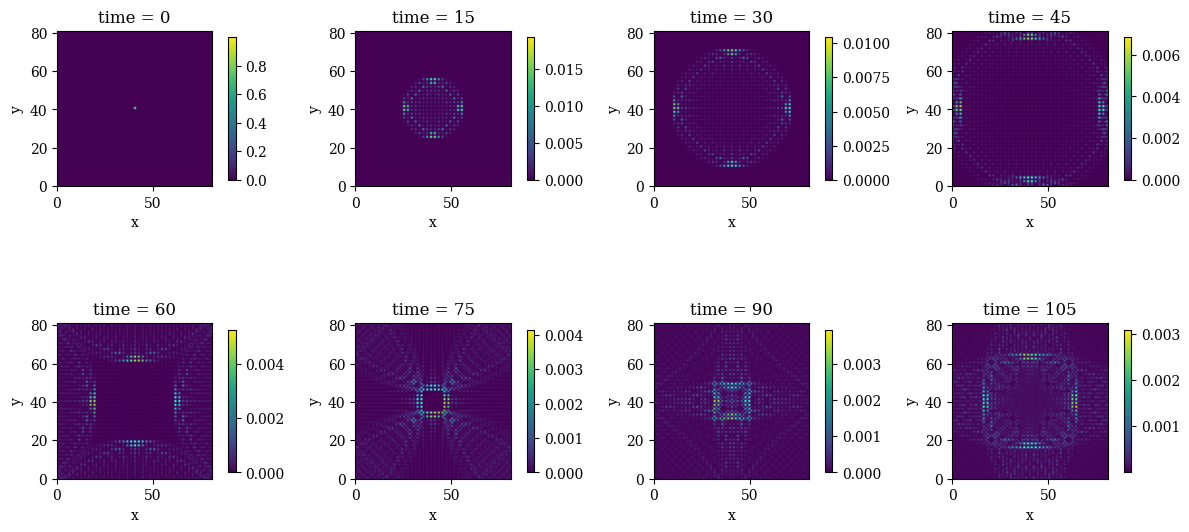

In [10]:
fig = plt.figure(figsize = (12,6))

time = 0
step = 15
prob = model.Get_prob()
num = 8

for i in range(num):
  ax = fig.add_subplot(num // 4, 4 ,i+1)
  im = ax.imshow(prob,origin = "lower",extent = [0,dimx,0,dimy])
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.set_title(f"time = {time}")
  plt.colorbar(im, ax = ax, fraction=0.04, pad=0.09)

  for _ in range(step):
    model.Evolve()
    prob = model.Get_prob()
    time += 1

plt.tight_layout()

fig.savefig("Images/2DimQW.pdf",format= "pdf",bbox_inches = "tight")